Here we'll put the bulk of the work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def check_data(df):
    df.info()
    print(df.head())

# Data Preprocessing
First let's tidy up the data we were given (See `datawasher.ipynb` for more details)

In [2]:
# The Visits Table
file_path = 'datasets_dirty/visits_log_us.csv'

try:
    open(file_path, 'r')
except FileNotFoundError:
    file_path = '/datasets/visits_log_us.csv'

v_df = pd.read_csv(
    file_path,
    parse_dates=['Start Ts', 'End Ts'],
    dtype=
        {
            'Device': 'category',
            'Source Id': 'category'
        }
)

v_df = v_df.rename(
    columns={
        'Uid': 'uid',
        'Device': 'device',
        'Start Ts': 'start_time',
        'End Ts': 'end_time',
        'Source Id': 'source_id'
    }
)
check_data(v_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   device      359400 non-null  category      
 1   end_time    359400 non-null  datetime64[ns]
 2   source_id   359400 non-null  category      
 3   start_time  359400 non-null  datetime64[ns]
 4   uid         359400 non-null  uint64        
dtypes: category(2), datetime64[ns](2), uint64(1)
memory usage: 8.9 MB
    device            end_time source_id          start_time  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   745903560

Going from memory usage: 79.3 MB to memory usage: 8.9 MB without any loss of data? Nice.
## The visits table (server logs with data on website visits):
- uid — user's unique identifier
    - Change from 'Uid' to 'uid'
- device — user's device
    - Change from 'Device' to 'device'
    - There's only two different values, so I'll change the type to category
- start_time — session start date and time
    - Change name from 'Start Ts' to 'start_time'
    - Looks like the seconds aren't included in this, I'll convert to datetime
- end_time — session end date and time
    - Change name from 'End Ts' to 'end_time'
    - Change to datetime type also
- source_id — identifier of the ad source the user came from
    - Change name from 'Source Id' to 'source_id'
    - There's only 10 unique values, so I changed this to category type. I'll come back and undo if I need to.

In [3]:
# The Orders Table
file_path = 'datasets_dirty/orders_log_us.csv'

try:
    open(file_path, 'r')
except FileNotFoundError:
    file_path = '/datasets/orders_log_us.csv'

o_df = pd.read_csv(
    file_path,
    parse_dates=['Buy Ts']
)

o_df = o_df.rename(
    columns={
        'Uid': 'uid',
        'Buy Ts': 'purchase_time',
        'Revenue': 'profit'
    }
)
check_data(o_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   purchase_time  50415 non-null  datetime64[ns]
 1   profit         50415 non-null  float64       
 2   uid            50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
        purchase_time  profit                   uid
0 2017-06-01 00:10:00   17.00  10329302124590727494
1 2017-06-01 00:25:00    0.55  11627257723692907447
2 2017-06-01 00:27:00    0.37  17903680561304213844
3 2017-06-01 00:29:00    0.55  16109239769442553005
4 2017-06-01 07:58:00    0.37  14200605875248379450


Going from memory usage: 4.4 MB to memory usage: 1.2 MB without any loss of data? Nice.
## The orders table (data on orders):
- uid — unique identifier of the user making an order
    - Change from 'Uid' to 'uid'
- purchase_time — order date and time
    - Change from 'Buy Ts' to 'purchase_time'
    - Convert to datetime type
- profit — Yandex.Afisha's revenue from the order
    - Change from 'Revenue' to 'profit'

In [4]:
# The Costs Table
file_path = 'datasets_dirty/costs_us.csv'

try:
    open(file_path, 'r')
except FileNotFoundError:
    file_path = '/datasets/costs_us.csv'

c_df = pd.read_csv(
    file_path,
    parse_dates=['dt'],
    dtype=
        {
            'Device': 'category',
            'source_id': 'category'
        }
)

c_df = c_df.rename(
    columns={
        'dt': 'date'
    }
)
check_data(c_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   category      
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 42.7 KB
  source_id       date  costs
0         1 2017-06-01  75.20
1         1 2017-06-02  62.25
2         1 2017-06-03  36.53
3         1 2017-06-04  55.00
4         1 2017-06-05  57.08


Going from memory usage: 206.2 KB to memory usage: 42.7 KB without any loss of data? Stellar move by me.
## The costs table (data on marketing expenses):
- source_id — ad source identifier
    - There's only 7 unique values. Convert to category type
- dt — date
    - change from 'dt' to 'date'
    - It only has dates, and no times. Convert to datetime type accordingly
- costs — expenses on this ad source on this day
    - This looks fine unchanged

# Report
```
Q: How many people use this every day, week, and month?

A:  Monthly average users =     23,228
    Weekly average users =      5,716
    Daily average users =       907 (about 15.88% of the weekly and 3.91% of the monthly users)
```

In [5]:
# Add columns indicating the year, month, week, and day of a users `start_time`
v_df['session_year']  = pd.to_datetime(v_df['start_time'].dt.isocalendar().year)
v_df['session_month'] = pd.to_datetime(v_df['start_time'].dt.to_period('M').dt.to_timestamp()) # Retains year and month
v_df['session_week'] = v_df['start_time'].dt.strftime('%Y-%U')  # Retains year and week
v_df['session_date'] = pd.to_datetime(v_df['start_time'].dt.date)

# v_df.sample(7)

In [6]:
# Calculating average daily, weekly, and monthly users
dau_total = (
    v_df.groupby('session_date')
    .agg({'uid': 'nunique'})
    .mean()
)

wau_total = (
    v_df.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

mau_total = (
    v_df.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)

# Also, sticky versions
sticky_wau = (dau_total / wau_total) * 100
sticky_mau = (dau_total / mau_total) * 100

print(f'dau = {int(dau_total)} wau = {int(wau_total)} mau = {int(mau_total)}')
print(f'sticky_wau = {float(sticky_wau):.2f}% sticky_mau = {float(sticky_mau):.2f}%')

dau = 907 wau = 5612 mau = 23228
sticky_wau = 16.18% sticky_mau = 3.91%


```
Q: What is the length of each session?

A: Average Session length = 10.73mins
```

In [7]:
# Finding session duration in seconds, then dividing by 60 to get mins, then print the average
v_df['session_duration_mins'] = (
    v_df['end_time'] - v_df['start_time']
).dt.seconds / 60

print(f"Average Session length = {float(v_df['session_duration_mins'].mean()):.2f}mins")

Average Session length = 10.73mins


```
Q: How many sessions are there per day?

A: Average Daily Sessions = 987.36 sessions
```

In [8]:
# Counting number of sessions per day, then printing the average
v_by_day = v_df.groupby('session_date').agg({
    'start_time': 'count'
})
v_by_day = v_by_day.rename(
    columns={
        'start_time': 'sessions'
    }
)
print(f"Average Daily Sessions = {float(v_by_day['sessions'].mean()):.2f} sessions")

Average Daily Sessions = 987.36 sessions


```
Q: What's the user retention rate?

A: See the Pivot Table below
```

In [9]:
# Calculating first session date to be used for other cohort calculations
first_session_date = v_df.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_session_date'

v_df = v_df.join(first_session_date, on='uid')

# For daily cohorts, if we want to later

# v_df['cohort_lifetime_days'] = ((
#         v_df['session_date']
#             -
#         v_df['first_session_date']
#     ) / np.timedelta64(1, 'D')
# ).astype(int)

In [10]:
# For weekly cohorts, if we want to later

# first_session_week = v_df.groupby(['uid'])['session_week'].min()
# first_session_week.name = 'first_session_week'

# v_df = v_df.join(first_session_week, on='uid')

# v_df['cohort_lifetime_weeks'] = ((
#         v_df['session_date']
#             -
#         v_df['first_session_date']
#     ) / np.timedelta64(1, 'W')
# ).astype(int)

In [11]:
# Calculating Monthly Cohort Lifetime in Months

first_session_month = v_df.groupby(['uid'])['session_month'].min()
first_session_month.name = 'first_session_month'

try:
    v_df = v_df.join(first_session_month, on='uid')
except:
    print('we already have first_session_month')

v_df['cohort_lifetime_months'] = (
    (
        v_df['session_date'].astype('datetime64[M]')
            -
        v_df['first_session_date'].astype('datetime64[M]')
    ) / np.timedelta64(1, 'M')
).astype(int)

# v_df.info()
# v_df[['start_time', 'session_year', 'session_month', 'session_date', 'first_session_month', 'cohort_lifetime_months']].head(20)


In [12]:
# v_df[['uid', 'cohort_lifetime_days', 'cohort_lifetime_weeks', 'cohort_lifetime_months']].sample(10)

In [13]:
# cohorts_weekly = (
#     v_df.groupby(['first_session_week', 'cohort_lifetime_weeks'])
#     .agg({'uid': 'nunique'})
#     .reset_index()
# )

# initial_users_count = cohorts_weekly[cohorts_weekly['cohort_lifetime_weeks'] == 0][ ['first_session_week', 'uid'] ]
# initial_users_count = initial_users_count.rename(
#     columns={'uid': 'weekly_cohort_users'}
# ) 

# cohorts_weekly = cohorts_weekly.merge(initial_users_count, on='first_session_week')

In [14]:
# Grouping by Cohort
cohorts_monthly = (
    v_df.groupby(['first_session_month', 'cohort_lifetime_months'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

initial_users_count = cohorts_monthly[cohorts_monthly['cohort_lifetime_months'] == 0][ ['first_session_month', 'uid'] ]
initial_users_count = initial_users_count.rename(
    columns={'uid': 'monthly_cohort_users'}
) 

cohorts_monthly = cohorts_monthly.merge(initial_users_count, on='first_session_month')

# Add retention rate column
cohorts_monthly['retention'] = cohorts_monthly['uid'] / cohorts_monthly['monthly_cohort_users']

In [15]:
# make and print table
retention_pivot = cohorts_monthly.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime_months',
    values='retention',
    aggfunc='sum'
)

# Format the percents
retention_pivot = retention_pivot.applymap(lambda x: '{:.2%}'.format(x))

# Get rid og the nan% values
retention_pivot = retention_pivot.replace('nan%', '')

retention_pivot


cohort_lifetime_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,100.00%,5.87%,5.58%,6.71%,6.77%,6.84%,5.99%,5.50%,5.39%,4.68%,4.03%,3.27%
2017-07-01,100.00%,5.13%,5.60%,5.35%,5.68%,4.63%,4.72%,4.38%,3.09%,2.77%,1.74%,
2017-08-01,100.00%,6.15%,6.10%,5.80%,4.42%,4.20%,4.09%,3.07%,2.62%,1.32%,,
2017-09-01,100.00%,6.77%,6.33%,4.14%,3.96%,3.74%,2.86%,2.37%,1.07%,,,
2017-10-01,100.00%,6.27%,4.37%,3.83%,3.44%,2.51%,2.04%,1.05%,,,,
2017-11-01,100.00%,5.08%,4.16%,3.63%,2.72%,2.15%,1.09%,,,,,
2017-12-01,100.00%,4.44%,3.41%,2.35%,2.02%,0.98%,,,,,,
2018-01-01,100.00%,4.33%,3.01%,2.20%,0.91%,,,,,,,
2018-02-01,100.00%,3.47%,2.27%,1.02%,,,,,,,,


```
Q: When do users start buying?

A: Average Conversion Rate = 16.90 days
```

In [16]:
# Find the earliest purchase date for each uid (aka for each user)
first_purchase_date = o_df.groupby(['uid'])['purchase_time'].min()
first_purchase_date.name = 'first_purchase_date'

user_conversion = (
    first_session_date.to_frame()
    .join(first_purchase_date, on='uid')
    .dropna()
    # .fillna('never')
)
user_conversion.reset_index(inplace=True)

# Add number of days between users first session and first purchase
user_conversion['conversion_days'] = ((
        user_conversion['first_purchase_date']
            -
        pd.to_datetime(user_conversion['first_session_date'])
    ) / np.timedelta64(1, 'D')
).astype(int)

# user_conversion.sample(10)

In [17]:
# user_conversion['conversion_days'].value_counts()
print(f"Average Conversion Rate = {float(user_conversion['conversion_days'].mean()):.2f} days")

Average Conversion Rate = 16.90 days


```
Q: How many orders do users make during a given period of time?

A: Average Number of Orders per Month = 1.27 orders
```

In [18]:
v_df[[
    'uid',
    'cohort_lifetime_months'
]].sample(10)

,uid,cohort_lifetime_months
234597,9485855643712336594,0
286389,1024772981751785679,0
158088,169366992868448841,0
46127,2482269812119783008,0
87425,18242750560488619933,0
33059,6565477541658030918,0
132722,8389491059110032976,0
315290,9906383852369537815,3
108038,692807211357664531,0
298354,1828808943515518698,0


In [19]:
o_df = o_df.merge(user_conversion[['uid', 'first_purchase_date']], on='uid', how='left')

# o_df.head()

In [20]:
o_df['user_age'] = ((
        o_df['purchase_time']
            -
        o_df['first_purchase_date']
    ) / np.timedelta64(1, 'D')
)

o_df.sample(10)

,purchase_time,profit,uid,first_purchase_date,user_age
33987,2018-02-10 15:20:00,1.83,12730357236532818415,2017-07-01 09:27:00,224.245139
25665,2017-12-23 23:52:00,1.47,2456184595159881859,2017-12-23 23:52:00,0.000000
8327,2017-09-19 22:26:00,7.33,5369553151817977993,2017-09-19 22:26:00,0.000000
28242,2018-01-05 18:48:00,4.28,17439576656914848326,2018-01-05 18:48:00,0.000000
24649,2017-12-17 22:39:00,0.85,5030689995223773055,2017-12-17 17:08:00,0.229861
35547,2018-02-18 16:44:00,2.93,11333340674998837191,2018-02-18 16:44:00,0.000000
30968,2018-01-25 13:32:00,0.61,6121327041270917515,2017-10-04 11:14:00,113.095833
26360,2017-12-27 09:12:00,4.28,1593842322606747611,2017-12-27 09:12:00,0.000000
12247,2017-10-11 19:31:00,8.55,11371297760860023056,2017-10-11 19:31:00,0.000000
14415,2017-10-24 21:27:00,2.75,2782735980490076186,2017-10-24 21:27:00,0.000000


In [21]:
# Group o_df by uid and calculate the total number of purchases per uid
purchase_count = o_df.groupby('uid')['purchase_time'].count()

# Calculate the duration in days, weeks, and months for each uid
duration_days = (o_df.groupby('uid')['purchase_time'].max() - o_df.groupby('uid')['purchase_time'].min()).dt.days
# duration_weeks = duration_days / 7
duration_months = duration_days / 30

# Calculate the average number of purchases per day, week, and month
# avg_purchases_per_day = np.where(duration_days == 0, 0, purchase_count / duration_days)
# avg_purchases_per_week = np.where(duration_weeks == 0, 0, purchase_count / duration_weeks)
avg_purchases_per_month = np.where(duration_months == 0, 0, purchase_count / duration_months)

# Combine the results into a new DataFrame
average_purchases_df = pd.DataFrame({
    'uid': purchase_count.index,
    # 'avg_purchases_per_day': avg_purchases_per_day,
    # 'avg_purchases_per_week': avg_purchases_per_week,
    'avg_purchases_per_month': avg_purchases_per_month
})

# Display the average purchases per day, week, and month
print(f"Average Number of Orders per Month = {float(average_purchases_df['avg_purchases_per_month'].mean()):.2f} orders")


Average Number of Orders per Month = 1.27 orders


```
Q: What is the average purchase size?

A: Average Size of Orders per User = 4.09 units of currency
```

In [22]:
# Group o_df by uid and calculate the total profit and number of purchases per uid
purchase_stats = o_df.groupby('uid').agg({'profit': 'sum', 'purchase_time': 'count'})

# Calculate the average purchase size per user
average_purchase_size_per_user = purchase_stats['profit'] / purchase_stats['purchase_time']

# Add the average purchase size per user to o_df
o_df = o_df.merge(average_purchase_size_per_user.rename('average_purchase_size_per_user'), on='uid')

# Display the average purchase size per user
average_purchase_size_per_user_df = o_df[['uid', 'average_purchase_size_per_user']].drop_duplicates()

print(f"Average Size of Orders per User {float(average_purchase_size_per_user_df['average_purchase_size_per_user'].mean()):.2f} units of currency")


Average Size of Orders per User 4.09 units of currency


```
Q: How much money do users bring?

A: Average Lifetime Value per User = 6.90 units of currency
```

In [23]:
total_ltv_data = o_df.groupby('uid')['profit'].sum().reset_index()

total_ltv_data = total_ltv_data.sort_values('profit', ascending=False)

# total_ltv_data.head(20)
print(f"Average LTV per User = {float(total_ltv_data['profit'].mean()):.2f} units of currency")


Average LTV per User = 6.90 units of currency


In [24]:
# purchase_stats = o_df.groupby('uid').agg({'profit': 'sum', 'purchase_time': 'count'})

# purchase_stats.sample(20)

# average_purchase_size = purchase_stats['profit'] / purchase_stats['purchase_time']

# average_purchase_size

```
Q: How much money was spent overall?

A: Total Overall Cost = 329131.62 units of currency
```

In [25]:
total_costs = c_df.agg({'costs': 'sum'})
print(f"Total Overall Cost = {float(total_costs):.2f} units of currency")
# total_costs

Total Overall Cost = 329131.62 units of currency


```
Q: How much money was spent per source?

A:  See the bar chart below
    Total Cost for source 3 =   141,321.63 units of currency, the highest by a large margin

    Total Cost for source 10 =  5,822.49 units of currency
    Total Cost for source 9 =   5,517.49 units of currency
    
    Sources 9 and 10 seem to be the least expensive, let's see how effective these sources are next.
```

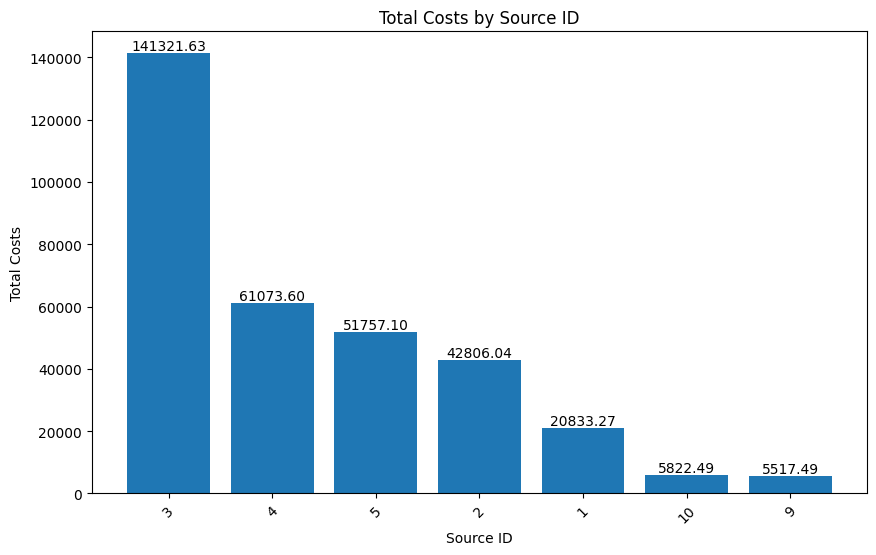

In [26]:
# Making this a Series Var for readability
# sourcely_costs = c_df.groupby('source_id').agg({'costs':'sum'}).reset_index()

# for _, row in sourcely_costs.iterrows():
#     print(f"Total Cost for source {row['source_id']} = {float(row['costs']):.2f} units of currency")

sourcely_costs = c_df.groupby('source_id').agg({'costs':'sum'}).reset_index().sort_values('costs', ascending=False)

# Plotting the total costs as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sourcely_costs['source_id'], sourcely_costs['costs'])
plt.xlabel('Source ID')
plt.ylabel('Total Costs')
plt.title('Total Costs by Source ID')
plt.xticks(rotation=45)

# Add the value to each bar as text
for i, value in enumerate(sourcely_costs['costs']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

```
Q: How much money was spent over time?

A: See the Line Graph below:
```

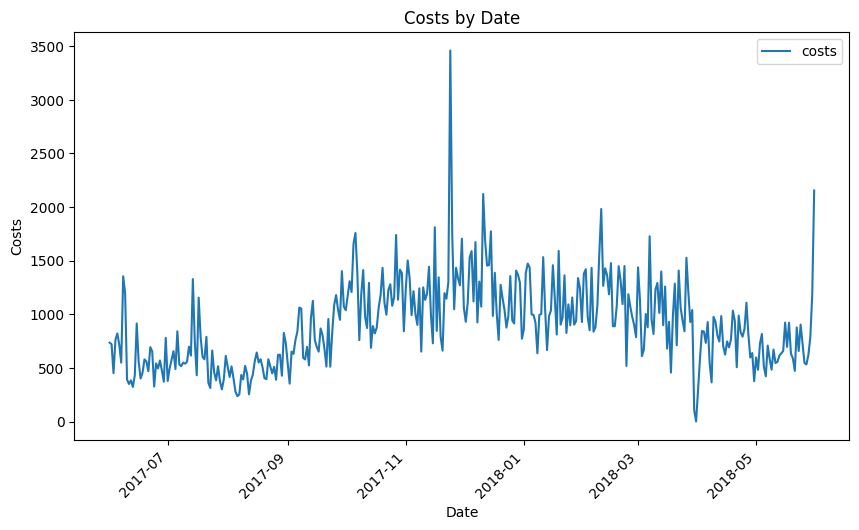

In [27]:
daily_costs = c_df.groupby('date').agg({'costs': 'sum'})

# Create the plot using Pandas plot()
daily_costs.plot(figsize=(10, 6))

# Customize the plot
plt.title('Costs by Date')
plt.xlabel('Date')
plt.ylabel('Costs')
plt.xticks(rotation=45)

# Display the plot
plt.show()


```
Q: How much did customer acquisition from each of the sources cost?

A: See the Bar Chart below:
    The highest CAC seems to be 1.89 units of currency for Source_id = 3
    The most efficent CACs seem to go to 9, 10, and 4
```

In [28]:
sourcely_users = (
    v_df.groupby(['source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

sourcely_users.columns = ['source_id', 'n_users']

cac_report = pd.merge(
    sourcely_costs,
    sourcely_users,
    on='source_id'
)

cac_report['cac'] = cac_report['costs'] / cac_report['n_users']
# sourcely_users

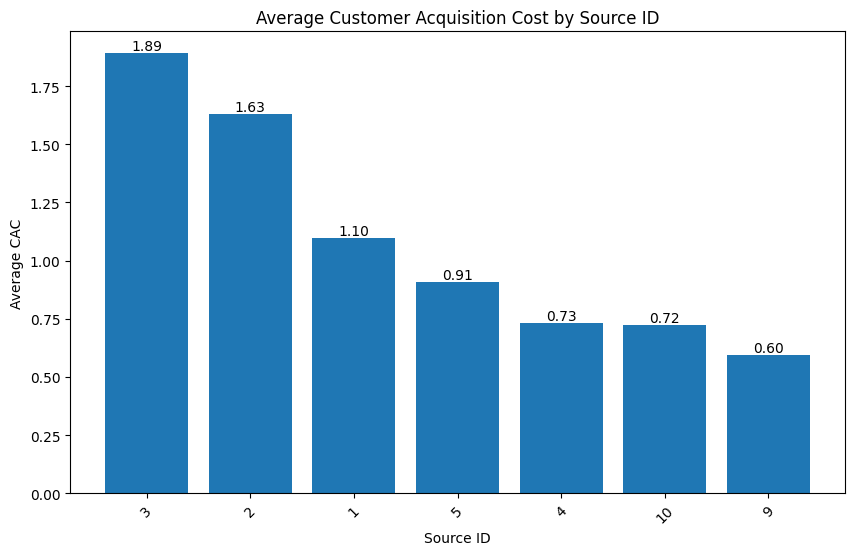

In [29]:
# Sort the dataframe by average CAC in descending order
cac_report_sorted = cac_report.sort_values('cac', ascending=False)

# Plotting the average CAC
plt.figure(figsize=(10, 6))
plt.bar(cac_report_sorted['source_id'], cac_report_sorted['cac'])
plt.xlabel('Source ID')
plt.ylabel('Average CAC')
plt.title('Average Customer Acquisition Cost by Source ID')
plt.xticks(rotation=45)

# Add the value to each bar as text
for i, value in enumerate(cac_report_sorted['cac']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


```
Q: How worthwhile were the investments?

A: Total Average Return on Investment per User = 4.78 units of currency
```

In [30]:
# Find the average lifetime value using our table from earlier
avg_ltv_per_user = total_ltv_data.agg({'profit':'mean'})

# Count the total number of unique users
total_n_users = v_df.agg({'uid': 'nunique'})

# Find the average Acquision cost per user
average_cac_per_user = total_costs[0] / total_n_users[0]

# Calculate Return on Investment
roi = avg_ltv_per_user / average_cac_per_user

# print('roi =', roi)
print(f"Total Average Return on Investment per User = {float(roi):.2f} units of currency")

Total Average Return on Investment per User = 4.78 units of currency


```
Next I'll show how the CAC, LTV, and ROI change depending on Ad Source and on Device
```

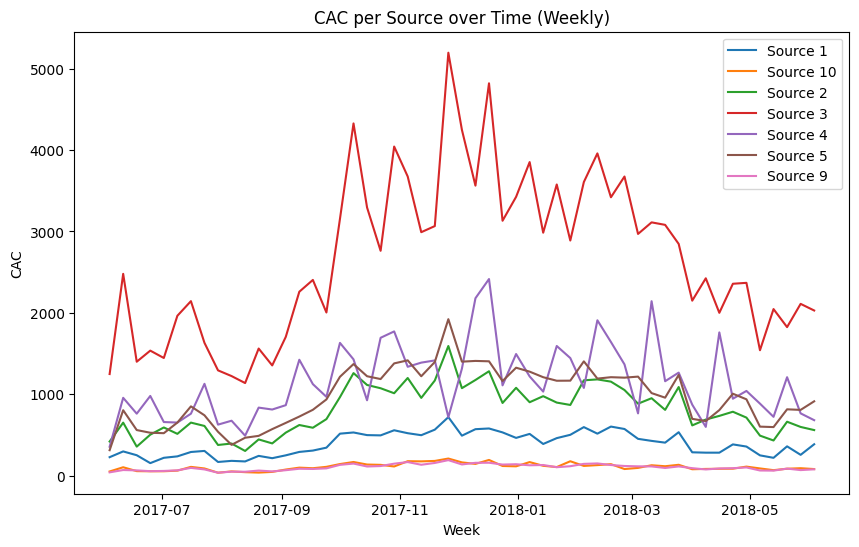

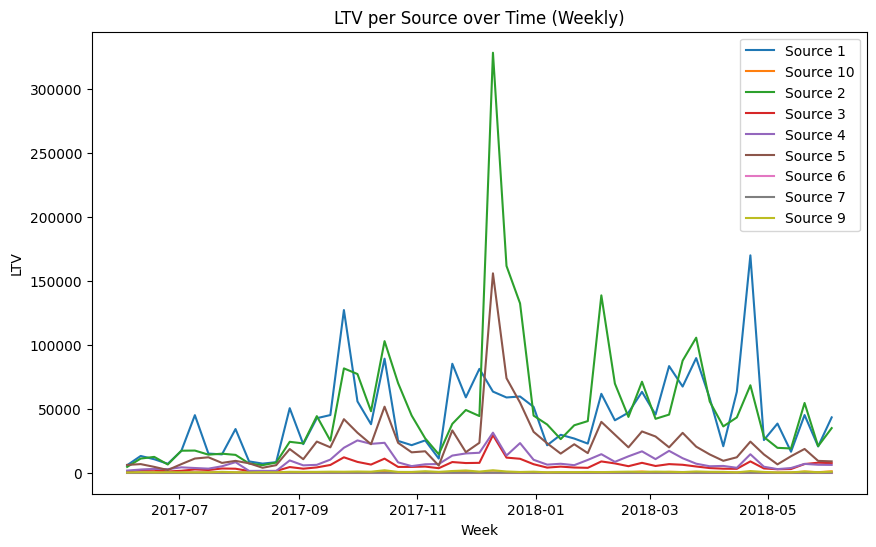

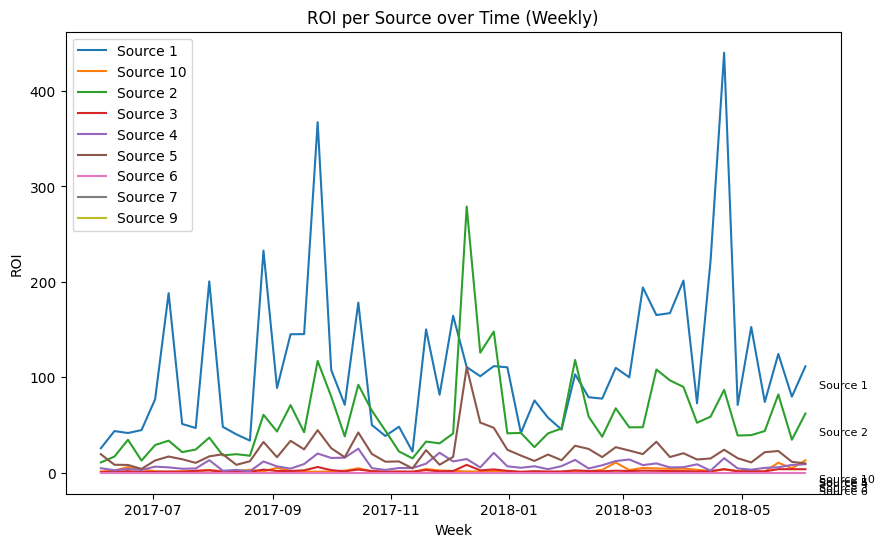

In [33]:
# Graph CAC, LTV, and ROI per Source Id per week

# Calculate CAC per source_id and time period
cac_per_source = c_df.groupby(['source_id', pd.Grouper(key='date', freq='W-SUN')]).agg({'costs': 'sum'}).reset_index()

# Calculate LTV per source_id and time period
# Merge visits and orders tables on 'uid' column
v_and_o_dfs = v_df.merge(o_df, on='uid')

# Group merged dataframe by 'source_id' and week of 'purchase_time', calculate LTV
sourcely_ltv = v_and_o_dfs.groupby(['source_id', pd.Grouper(key='purchase_time', freq='W-SUN')]).agg(
    ltv=('profit', 'sum'),
    unique_users=('uid', 'nunique')
).reset_index()

# Calculate ROI per source_id and time period
roi_per_source = sourcely_ltv.copy()
roi_per_source['roi'] = roi_per_source['ltv'] / cac_per_source['costs']

# Plotting CAC per source_id
plt.figure(figsize=(10, 6))
for source_id, group in cac_per_source.groupby('source_id'):
    plt.plot(group['date'], group['costs'], label=f"Source {source_id}")
plt.xlabel('Week')
plt.ylabel('CAC')
plt.title('CAC per Source over Time (Weekly)')
plt.legend()
plt.show()

# Plotting LTV per source_id
plt.figure(figsize=(10, 6))
for source_id, group in sourcely_ltv.groupby('source_id'):
    plt.plot(group['purchase_time'], group['ltv'], label=f"Source {source_id}")
plt.xlabel('Week')
plt.ylabel('LTV')
plt.title('LTV per Source over Time (Weekly)')
plt.legend()
plt.show()

# Plotting ROI per source_id
plt.figure(figsize=(10, 6))
for source_id, group in roi_per_source.groupby('source_id'):
    plt.plot(group['purchase_time'], group['roi'], label=f"Source {source_id}")
    last_data_point = group.iloc[-1]  # Get the last data point for each source_id
    plt.annotate(f"Source {source_id}", xy=(last_data_point['purchase_time'], last_data_point['roi']), xytext=(10, -10),
                 textcoords='offset points', ha='left', va='top', color='black', fontsize=8)

plt.xlabel('Week')
plt.ylabel('ROI')
plt.title('ROI per Source over Time (Weekly)')
plt.legend()
plt.show()



```
We see that CAC for Source 3 is much higher than all the others pretty consistently and might want to reconsider our partnership with them.

In the second Graph, we see that Source 2 and 5 had pretty significant spikes in LTVs around the end of December. Whatever they were doing was working.

Finally in the third graph we see that Source 1 was most consistently the highest performer. We also see that 10, 3, 4, 6, 7, and 9 are practically flatlining and might want to reconsider them as well.
```

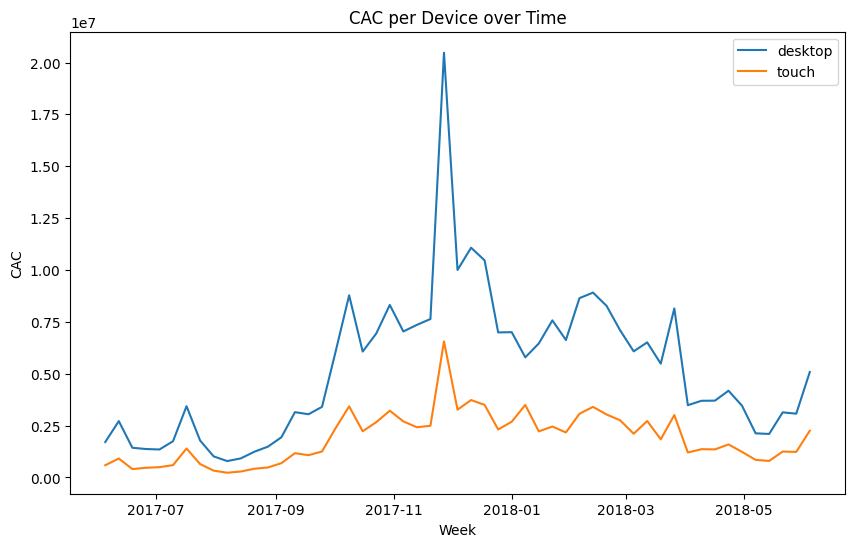

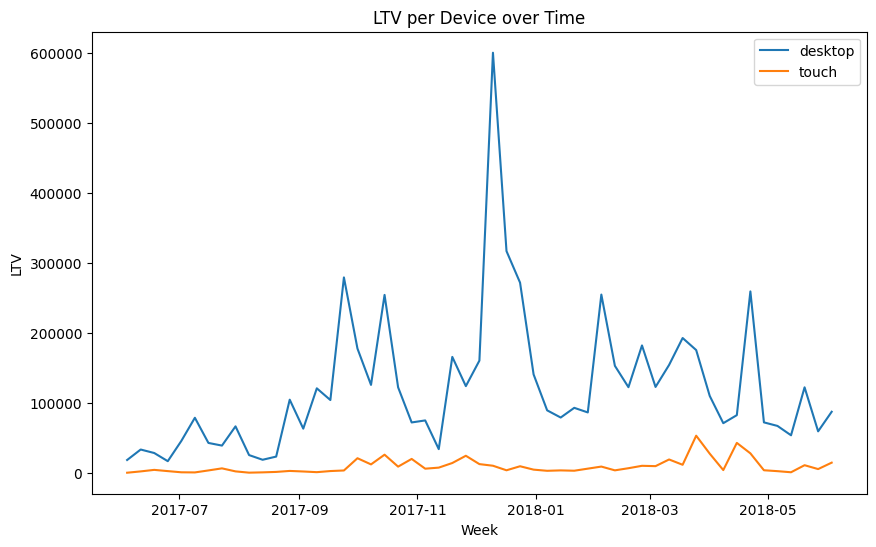

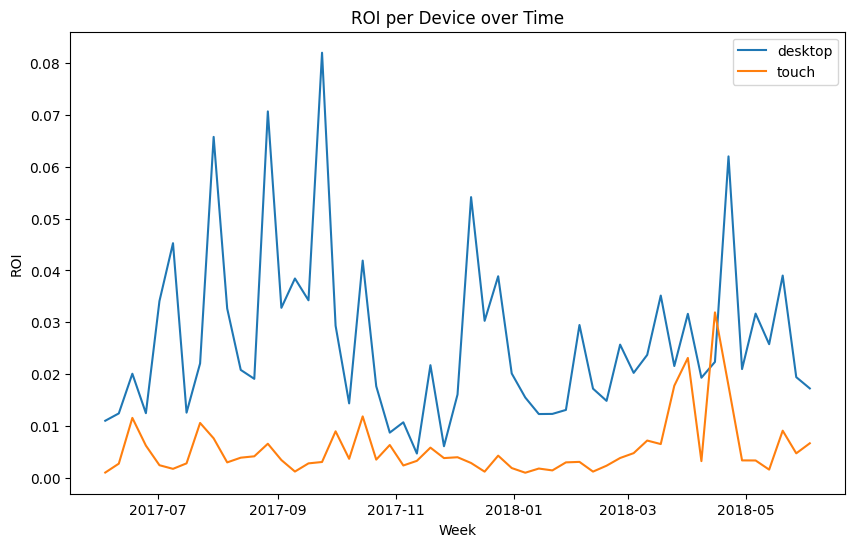

In [32]:
# Graph CAC, LTV, and ROI per device per week

# Extract the date part from the "end_time" column in v_df
v_df['date'] = pd.to_datetime(v_df['end_time'].dt.date)

# Merge v_df and c_df based on the date part
v_and_c_dfs = v_df.merge(c_df, on='date')

# Calculate CAC per device and week
cac_per_device_week = v_and_c_dfs.groupby([v_and_c_dfs['device'], pd.Grouper(key='date', freq='W-MON')])['costs'].sum().reset_index()

# Calculate LTV per device and week

# Calculate LTV per device and week
ltv_per_device_week = v_and_o_dfs.groupby([v_and_o_dfs['device'], pd.Grouper(key='purchase_time', freq='W-SUN')])['profit'].sum().reset_index()

# Calculate ROI per device and week
roi_per_device_week = ltv_per_device_week.copy()
roi_per_device_week['roi'] = roi_per_device_week['profit'] / cac_per_device_week['costs']

# Plotting CAC per device
plt.figure(figsize=(10, 6))
for device, group in cac_per_device_week.groupby('device'):
    plt.plot(group['date'], group['costs'], label=device)
plt.xlabel('Week')
plt.ylabel('CAC')
plt.title('CAC per Device over Time (Weekly)')
plt.legend()
plt.show()

# Plotting LTV per device
plt.figure(figsize=(10, 6))
for device, group in ltv_per_device_week.groupby('device'):
    plt.plot(group['purchase_time'], group['profit'], label=device)
plt.xlabel('Week')
plt.ylabel('LTV')
plt.title('LTV per Device over Time (Weekly)')
plt.legend()
plt.show()

# Plotting ROI per device
plt.figure(figsize=(10, 6))
for device, group in roi_per_device_week.groupby('device'):
    plt.plot(group['purchase_time'], group['roi'], label=device)
plt.xlabel('Week')
plt.ylabel('ROI')
plt.title('ROI per Device over Time (Weekly)')
plt.legend()
plt.show()


```
At first we see that the CAC for Desktop users is much higher, but in the nest graph we see that the returns are also much higher. 

In the bottom graph, we see indeed that the higher profits for Desktop make up for the higher costs and indeed outperforms touch devices almost every week out of the year.
```

```
And Questions or concerns or tyops you'd like to being to my attention, please eMail me whenever is convenient for you.
```